In [1]:
import os
import librosa
import timeit

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
if torch.cuda.is_available():
    device=torch.device('cuda:0')
else:
    device=torch.device('cpu')

from plotly import graph_objs as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML, Audio, display_html, clear_output
sr = 16000
batch_size = 32

# Load data
We are testing the model on 10% of the train data. For this purpose we can load all the data to RAM. Later we will train a model on the full data where we will have to handle data loading inside the DataLoader.

In [2]:
ROOT_DIR = "D:\\Projects\\silero-audio-classification"
PERCENT = 1 # take PERCENT% of the data

In [3]:
def load_train_val(ROOT_DIR):
    train, val = train_test_split(pd.read_csv("train.csv"))
    return train, val

In [4]:
train, val = load_train_val(ROOT_DIR)

train = train[:len(train)*PERCENT//100]
val = val[:len(val)*PERCENT//100]
print(train.head(), end="\n" + "-"*50 + "\n")
target_to_text = {elem: name for name, elem in zip(train["label"].unique(), train["target"].unique())}
N = len(target_to_text)
print(f"{N} target classes found:")
print(target_to_text)

        Unnamed: 0             wav_path   label  target
26776        26776  train/e/127f0bf.wav  speech       0
155987      155987  train/9/ab864ca.wav  speech       0
69099        69099  train/a/f199356.wav   music       1
179160      179160  train/3/b9bfc0b.wav  speech       0
171461      171461  train/0/4ded7cb.wav   noise       2
--------------------------------------------------
3 target classes found:
{0: 'speech', 1: 'music', 2: 'noise'}


In [5]:
def process_wav(ROOT_DIR, filepath):
    path = ROOT_DIR + '\\' + filepath
    wav, _ = librosa.load(path, sr=sr)
    melspec = librosa.feature.melspectrogram(wav, sr=sr)
    freq = melspec.sum(axis=1)
    freqdb = torch.from_numpy(librosa.power_to_db(freq)).to(device)
    mean = freqdb.mean()
    std = freqdb.std()
    eps = 1e-6
    freq_norm = (freqdb - mean) / (std + eps)
    freq_min, freq_max = freq_norm.min(), freq_norm.max()
    freq_scaled = 255 * (freq_norm - freq_min) / (freq_max - freq_min)
    freq = freq_scaled.float().cpu()
    return freq

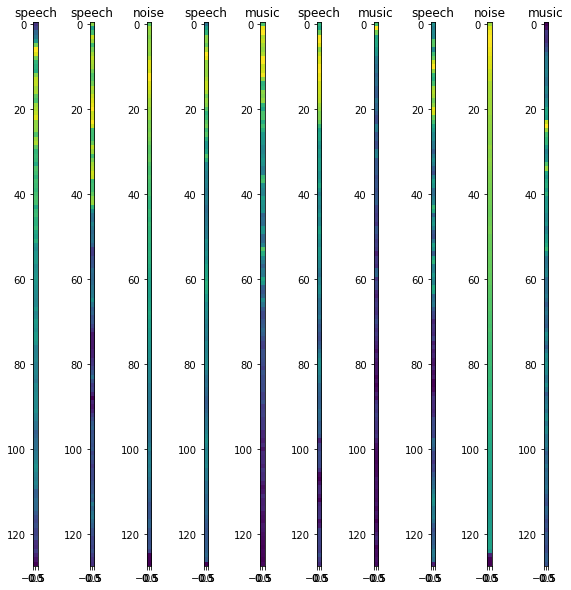

In [59]:
fig, ax = plt.subplots(1, 10, figsize=(10, 10))
for i, row in enumerate(train.sample(10).values):
    filepath, label = row[1], row[2]
    freq = process_wav(ROOT_DIR, filepath)
    ax[i].imshow(freq.unsqueeze(1))
    ax[i].set_title(f"{label}")
# fig.tight_layout()

In [7]:
class FreqDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = [[], []]
        for filename, target in tqdm(zip(data["wav_path"], data["target"]), total=len(data)):
            target_ = torch.tensor(target).long()
            freq = process_wav(ROOT_DIR, filename).unsqueeze(0)
            self.data[0].append(freq)
            self.data[1].append(target_)
        
    def __getitem__(self, index):
        return self.data[0][index].to(device), self.data[1][index]
    
    def __len__(self):
        assert len(self.data[0]) == len(self.data[1])
        return len(self.data[0])

In [8]:
train_dataset = FreqDataset(train)
validation_dataset = FreqDataset(val)

In [9]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, drop_last=True)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, drop_last=True)

In [10]:
batch_X_train, batch_y_train = next(iter(train_dataloader))
print(type(batch_X_train), batch_X_train.shape)
print(type(batch_y_train), batch_y_train.shape)

<class 'torch.Tensor'> torch.Size([32, 1, 128])
<class 'torch.Tensor'> torch.Size([32])


# Calculate the mean image and use it to calculate a baseline loss

Baseline mean loss: 2833.985107421875


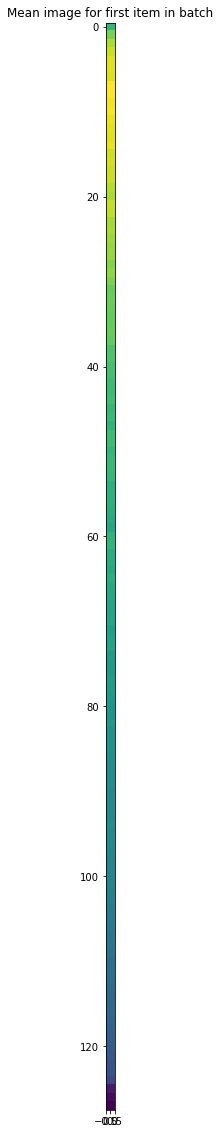

In [60]:
mean_image = torch.zeros(32, 1, 128)
for batch in train_dataloader:
    mean_image += batch[0].cpu()
mean_image = mean_image.squeeze(1)
mean_image /= len(train_dataloader)
plt.figure(figsize=(20, 20))
plt.imshow(mean_image[0].cpu().unsqueeze(1))
plt.title("Mean image for first item in batch")
loss = nn.MSELoss()
mean_loss = torch.zeros(1)
for batch in train_dataloader:
    mean_loss += loss(mean_image, batch[0].cpu())
mean_loss /= len(train_dataloader)
print(f"Baseline mean loss: {mean_loss.item()}")

# Define the AutoEncoder

In [216]:
class AutoEncoder(nn.Module):
    def __init__(self, bottleneck=20):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, 7, 3, 1),
            nn.Dropout(p=0.2),
            nn.BatchNorm1d(16),
            nn.ReLU(True),
            nn.Conv1d(16, 64, 4, 2, 1),
            nn.Dropout(p=0.2),
            nn.BatchNorm1d(64),
            nn.ReLU(True),
            nn.Conv1d(64, 64, 3, 1, 1),
            nn.Dropout(p=0.2),
            nn.BatchNorm1d(64),
            nn.ReLU(True),
            nn.Conv1d(64, 64, 3, 1, 1),
            nn.Dropout(p=0.2),
            nn.BatchNorm1d(64),
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(1344, 750),
            nn.Dropout(p=0.2),
            nn.ReLU(True),
            nn.Linear(750, 500),
            nn.Dropout(p=0.2),
            nn.ReLU(True),
            nn.Linear(500, 250),
            nn.Dropout(p=0.2),
            nn.ReLU(True),
            nn.Linear(250, 100),
            nn.Dropout(p=0.2),
            nn.Linear(100, bottleneck),
            nn.Dropout(p=0.2),
            nn.ReLU(True)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck, 60),
            nn.Dropout(p=0.2),
            nn.ReLU(True),
            nn.Linear(60, 80),
            nn.Dropout(p=0.2),
            nn.ReLU(True),
            nn.Linear(80, 100),
            nn.Dropout(p=0.2),
            nn.ReLU(True),
            nn.Linear(100, 128)
        )
        
    def forward(self, x):
        x = self.encoder(x)
#         x = x.unsqueeze(1)
#         print(x.shape)
        x = self.decoder(x)
#         print(x.shape)
        return x.view(-1, 128)

In [217]:
ae = AutoEncoder(30)
ae = ae.to(device)
# net = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)
# net.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# net.fc = nn.Linear(in_features=512, out_features=N, bias=True)
history = []
loss = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=0.00001)
batch_X, batch_y = next(iter(train_dataloader))
out = ae(batch_X)
print(out.shape)

ae

torch.Size([32, 128])


AutoEncoder(
  (encoder): Sequential(
    (0): Conv1d(1, 16, kernel_size=(7,), stride=(3,), padding=(1,))
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Conv1d(16, 64, kernel_size=(4,), stride=(2,), padding=(1,))
    (5): Dropout(p=0.2, inplace=False)
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): Dropout(p=0.2, inplace=False)
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (13): Dropout(p=0.2, inplace=False)
    (14): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU(inplace=True)
    (16): Flatten()
    (17): Linear(in_features=1344, ou

# Train and validate the AutoEncoder

In [218]:
def train_epoch(ae, train_dataloader, optimizer, loss):
    ae.train()
    loss_train = []
    
    for batch_X, _ in train_dataloader:
        batch_X = batch_X.to(device)
        out = ae(batch_X)
        train_batch_loss = loss(out, batch_X.squeeze(1))
        
        optimizer.zero_grad()
        train_batch_loss.backward()
        optimizer.step()
        
        loss_train.append(train_batch_loss.item())

    return np.array(loss_train).mean()


def validate(ae, validation_dataloader, loss):
    ae.eval()
    loss_val = []
    
    for batch_X, _ in validation_dataloader:
        batch_X = batch_X.to(device)
        batch_loss = []
        with torch.no_grad():
            out = ae(batch_X)
            batch_loss.append(loss(out, batch_X.squeeze(1)).item())
        batch_loss = np.array(batch_loss).mean()
        
        loss_val.append(batch_loss)

    
    return np.array(loss_val).mean()

The dark dotted line is the baseline mean loss calculated earlier.

In [219]:
N_EPOCHS = 500
n_val = 2

losses_train = []
epochs_train = []
losses_val = []
accs_val = []
epochs_val = []

fig_loss = go.Figure(    
)

fig_loss.add_scatter(
    y=losses_train, x=epochs_train,
    name='train loss'
)
fig_loss.add_scatter(
    y=losses_val, x=epochs_val,
    name='validation loss'
)
fig_loss.add_shape(
    type="line", x0=0, x1=1, xref="paper", y0=mean_loss.item(), y1=mean_loss.item(), line=dict(width=3, dash="dot")
)

fig_loss.update_layout(height=500, width=1300, title_text='AutoEncoder')
fig_loss = go.FigureWidget(fig_loss)
display(fig_loss)

if not os.path.exists("models\\tmp\\ae"):
        os.makedirs("models\\tmp\\ae")
        
for epoch in tqdm(range(N_EPOCHS)):
#     loss_train = train_epoch(net, train_dataloader, optimizer, loss)
    loss_train = train_epoch(ae, train_dataloader, optimizer, loss)
    losses_train.append(loss_train)
    epochs_train.append(epoch)
    
    if epoch % n_val == 0:
        loss_val = validate(ae, validation_dataloader, loss)
        losses_val.append(loss_val)
        epochs_val.append(epoch)
        
    fig_loss.data[0].x = epochs_train
    fig_loss.data[0].y = losses_train
    
    fig_loss.data[1].x = epochs_val
    fig_loss.data[1].y = losses_val
    
    torch.save(ae.state_dict(), f"models\\tmp\\ae\\{epoch}")

FigureWidget({
    'data': [{'name': 'train loss', 'type': 'scatter', 'uid': '6a472b40-122e-403d-a53b-f0fea603…

KeyboardInterrupt: 

# Check out the autoencoder in action

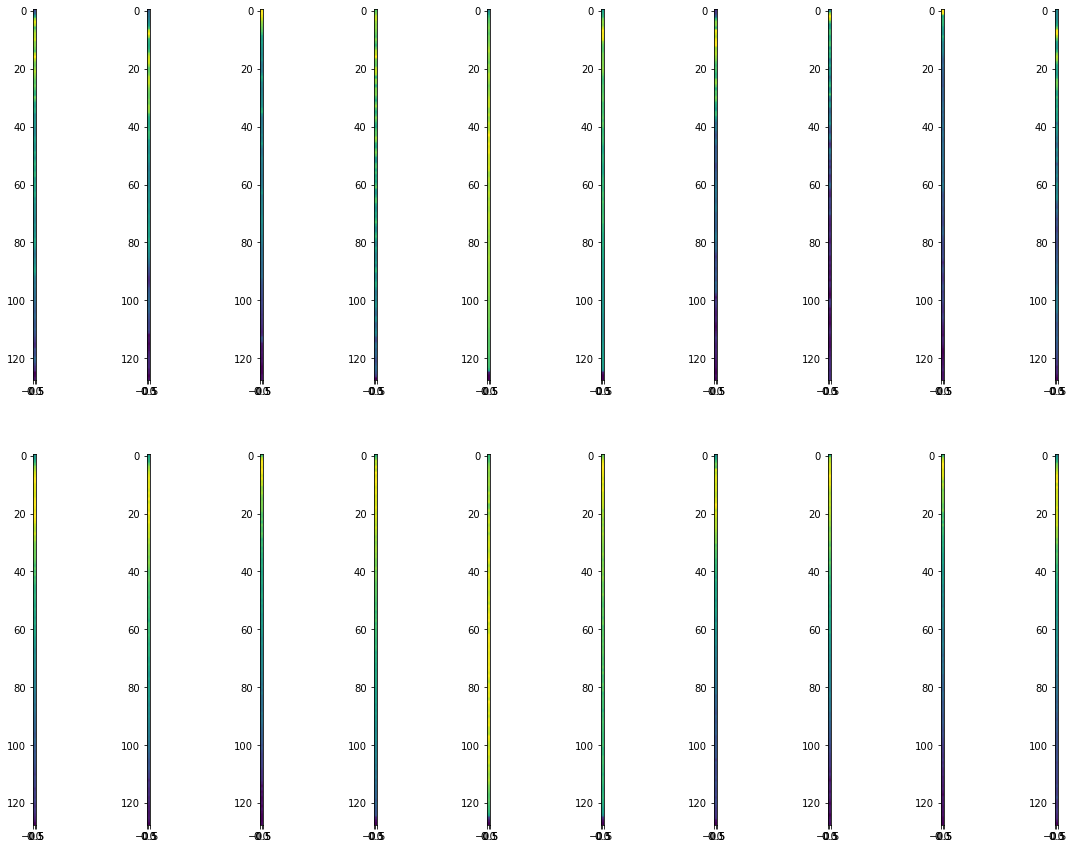

In [104]:
batch = next(iter(train_dataloader))
fig, ax = plt.subplots(2, 10, figsize=(20, 15))
for x, i in zip(batch[0], range(10)):
    image = x.squeeze(0).cpu()
    reconstruction = ae(x.unsqueeze(0)).detach().cpu().squeeze(0)
    ax[0, i].imshow(image.unsqueeze(1))
    ax[1, i].imshow(reconstruction.unsqueeze(1))

In [10]:
import torch.nn as nn
import torch.nn.functional as F


class FreqNet(nn.Module):
    # big model
    def __init__(self, N):
        super(FreqNet, self).__init__()
        # head
        self.conv = nn.Conv1d(1, 64, 4, stride=2)
        self.batchnorm = nn.BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=4, stride=2, padding=1, dilation=1, ceil_mode=False)

        # block 1
        self.conv1_1 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.drop1_1 = nn.Dropout(0.2)
        self.batchnorm1_1 = nn.BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu_1 = nn.ReLU(inplace=True)
        self.conv2_1 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.batchnorm2_1 = nn.BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        # block 2
        self.conv1_2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.drop1_2 = nn.Dropout(0.2)
        self.batchnorm1_2 = nn.BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu_2 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.batchnorm2_2 = nn.BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_2 = nn.Conv1d(64, 128, kernel_size=1, stride=2, padding=1, bias=False)
        self.batchnorm2_2 = nn.BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        # block 3
#         self.conv1_3 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1, bias=False)
#         self.drop1_3 = nn.Dropout(0.2)
#         self.batchnorm1_3 = nn.BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#         self.relu_3 = nn.ReLU(inplace=True)
#         self.conv2_3 = nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
#         self.batchnorm2_3 = nn.BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#         self.conv3_3 = nn.Conv2d(128, 256, kernel_size=1, stride=2, padding=1, bias=False)
#         self.batchnorm2_3 = nn.BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        
#         # block 3
#         self.conv1_4 = nn.Conv1d(256, 512, kernel_size=3, stride=1, padding=1, bias=False)
#         self.drop1_4 = nn.Dropout(0.2)
#         self.batchnorm1_4 = nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#         self.relu_4 = nn.ReLU(inplace=True)
#         self.conv2_4 = nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1, bias=False)
#         self.batchnorm2_4 = nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#         self.conv3_4 = nn.Conv2d(256, 512, kernel_size=1, stride=2, padding=1, bias=False)
#         self.batchnorm2_4 = nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        self.finalpool = nn.AdaptiveAvgPool1d(output_size=1)
        self.linear = nn.Linear(128, N, bias=False)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.to(device)
        # head
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # block 1
        x_remember = x.clone()
        x = self.conv1_1(x)
        x = self.drop1_1(x)
        x = self.batchnorm1_1(x)
        x = self.relu_1(x)
        x = self.conv2_1(x)
        x = self.batchnorm2_1(x)
        
        x = x + x_remember
        x = F.relu(x)

        # block 2
        x_remember = x.clone()
        x = self.conv1_2(x)
        x = self.drop1_2(x)
        x = self.batchnorm1_2(x)
        x = self.relu_2(x)
        x = self.conv2_2(x)
        x = self.batchnorm2_2(x)
        x = x + F.pad(x_remember, [0, 0, 32, 32, 0, 0])
        x = F.relu(x)

#         # block 3
#         x_remember = x.clone()
#         x = self.conv1_3(x)
#         x = self.drop1_3(x)
#         x = self.batchnorm1_3(x)
#         x = self.relu_3(x)
#         x = self.conv2_3(x)
#         x = self.batchnorm2_3(x)
#         x = x + F.pad(x_remember, [0, 0, 64, 64, 0, 0])
#         x = F.relu(x)
        
#         # block 4
#         x_remember = x.clone()
#         x = self.conv1_4(x)
#         x = self.drop1_4(x)
#         x = self.batchnorm1_4(x)
#         x = self.relu_4(x)
#         x = self.conv2_4(x)
#         x = self.batchnorm2_4(x)
#         x = x + F.pad(x_remember, [0, 0, 128, 128, 0, 0])
#         x = F.relu(x)

        # end
        x = self.finalpool(x)
        #         print(x.shape)
        x = self.linear(x.view(batch_size, -1))
        #         x = F.log_softmax(x, dim=1)

        return x
    

import torch.nn as nn
import torch.nn.functional as F


class FreqSimpleNet(nn.Module):
    # small model
    def __init__(self, N):
        super(FreqSimpleNet, self).__init__()
        # head
        self.conv = nn.Conv1d(1, 64, 7, stride=2)
        self.batchnorm = nn.BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=5, stride=1, padding=1, dilation=1, ceil_mode=False)

#         self.finalpool = nn.AdaptiveAvgPool1d(output_size=1)
        self.linear = nn.Linear(64*59, 64*30)
    
        # block 1
        self.conv1_1 = nn.Conv1d(64, 128, kernel_size=4, stride=1, padding=1, bias=False)
        self.drop1_1 = nn.Dropout(0.2)
        self.batchnorm1_1 = nn.BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu_1 = nn.ReLU(inplace=True)
        self.conv2_1 = nn.Conv1d(128, 128, kernel_size=4, stride=1, padding=1, bias=False)
        self.batchnorm2_1 = nn.BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        
        self.linear1 = nn.Linear(128*28, N, bias=False)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.to(device)
        # head
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # block 1
#         print(x.shape)
        x = self.linear(x.view(batch_size, -1)).view(batch_size, 64, -1)
        
        x = self.conv1_1(x)
        x = self.drop1_1(x)
        x = self.batchnorm1_1(x)
        x = self.relu_1(x)
        x = self.conv2_1(x)
        x = self.batchnorm2_1(x)
#         print(x.shape)
        x = self.linear1(x.view(batch_size, -1))
            
        return x

In [11]:
net = FreqSimpleNet(3)
# net = torchvision.models.resnet34(pretrained=True)
# net.fc = nn.Linear(512, 50)
# net.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
net = net.to(device)
history = []
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.000005)
net

FreqSimpleNet(
  (conv): Conv1d(1, 64, kernel_size=(7,), stride=(2,))
  (batchnorm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool1d(kernel_size=5, stride=1, padding=1, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=3776, out_features=1920, bias=True)
  (conv1_1): Conv1d(64, 128, kernel_size=(4,), stride=(1,), padding=(1,), bias=False)
  (drop1_1): Dropout(p=0.2, inplace=False)
  (batchnorm1_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_1): ReLU(inplace=True)
  (conv2_1): Conv1d(128, 128, kernel_size=(4,), stride=(1,), padding=(1,), bias=False)
  (batchnorm2_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=3584, out_features=3, bias=False)
)

In [12]:
batch_X, batch_y = next(iter(train_dataloader))
net(batch_X);

In [13]:
def train_epoch(net, train_dataloader, optimizer, loss):
    net.train()
    loss_train = []
    
    for batch_X, batch_y_true in train_dataloader:
        batch_X = batch_X.to(device)
        batch_y_true = batch_y_true.to(device)
        out = net(batch_X)
        train_batch_loss = loss(out, batch_y_true)
        
        optimizer.zero_grad()
        train_batch_loss.backward()
        optimizer.step()
        
        loss_train.append(train_batch_loss.item())

    return np.array(loss_train).mean()


def validate(net, validation_dataloader, loss):
    net.eval()
    pred = torch.tensor([]).to(device)
    true = torch.tensor([]).to(device)
    loss_val = []
    
    for batch_X, batch_y_true in validation_dataloader:
        batch_size = batch_X.size(0)
        batch_X = batch_X.to(device)
        batch_y_true = batch_y_true.to(device)
        with torch.no_grad():
            out = net(batch_X)
            batch_y_pred = out.argmax(axis=1)
        pred = torch.cat((pred, batch_y_pred))
        true = torch.cat((true, batch_y_true))
        
        batch_loss = loss(out, batch_y_true)
        loss_val.append(batch_loss.item())

    acc = accuracy_score(true.cpu(), pred.cpu())
    
    return acc, np.array(loss_val).mean()

In [14]:
N_EPOCHS = 500
n_val = 2

losses_train = []
epochs_train = []
losses_val = []
accs_val = []
epochs_val = []

fig_loss = make_subplots(
    cols=2, rows=1,
    subplot_titles=['Loss', 'Accuracy'], column_widths=[0.7, 0.3]
    
)

fig_loss.add_scatter(
    y=losses_train, x=epochs_train,
    name='train loss', row=1, col=1
)
fig_loss.add_scatter(
    y=losses_val, x=epochs_val,
    name='validation loss', row=1, col=1
)
fig_loss.add_scatter(
    y=losses_val, x=epochs_val,
    name='validation accuracy', row=1, col=2
)
fig_loss.update_layout(height=500, width=1300, title_text='FreqNet1d')
fig_loss = go.FigureWidget(fig_loss)
display(fig_loss)

if not os.path.exists("models\\tmp\\1d"):
        os.makedirs("models\\tmp\\1d")
        
for epoch in tqdm(range(N_EPOCHS)):
#     loss_train = train_epoch(net, train_dataloader, optimizer, loss)
    loss_train = train_epoch(net, train_dataloader, optimizer, loss)
    losses_train.append(loss_train)
    epochs_train.append(epoch)
    
    if epoch % n_val == 0:
        acc, loss_val = validate(net, validation_dataloader, loss)
        accs_val.append(acc)
        losses_val.append(loss_val)
        epochs_val.append(epoch)
        
    fig_loss.data[0].x = epochs_train
    fig_loss.data[0].y = losses_train
    
    fig_loss.data[1].x = epochs_val
    fig_loss.data[1].y = losses_val
    
    fig_loss.data[2].x = epochs_val
    fig_loss.data[2].y = accs_val
    
    torch.save(net.state_dict(), f"models\\tmp\\1d\\{epoch}")

FigureWidget({
    'data': [{'name': 'train loss',
              'type': 'scatter',
              'uid': '45e2…

We can choose the best model according to the maximu of validation accuracy. The model on different training epochs is saved at tmp\\1d.

Cross validation is recommended to prevent overfitting to the validation set, but I don't have the resources to do that.

In [23]:
best_acc_epoch = torch.tensor(accs_val).argmax().item()*2

In [38]:
net = FreqSimpleNet(3)
net.load_state_dict(torch.load(f"models\\tmp\\1d\\{best_acc_epoch}"))
net.to(device)

FreqSimpleNet(
  (conv): Conv1d(1, 64, kernel_size=(7,), stride=(2,))
  (batchnorm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool1d(kernel_size=5, stride=1, padding=1, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=3776, out_features=1920, bias=True)
  (conv1_1): Conv1d(64, 128, kernel_size=(4,), stride=(1,), padding=(1,), bias=False)
  (drop1_1): Dropout(p=0.2, inplace=False)
  (batchnorm1_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_1): ReLU(inplace=True)
  (conv2_1): Conv1d(128, 128, kernel_size=(4,), stride=(1,), padding=(1,), bias=False)
  (batchnorm2_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=3584, out_features=3, bias=False)
)

# Make submission

In [39]:
submit_features = pd.read_csv('sample_submission.csv')
submit_features.head()

,wav_path,target
0,val/e/b7cf2c4.wav,0
1,val/0/8f1489d.wav,0
2,val/f/14b7304.wav,0
3,val/2/3763132.wav,0
4,val/0/51c4271.wav,0


In [40]:
class SubmissionDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = []
        for filename in tqdm(data["wav_path"], total=len(data)):
            self.data.append(filename)
        
    def __getitem__(self, index):
        return process_wav(ROOT_DIR, self.data[index]).unsqueeze(0), self.data[index]
    
    def __len__(self):
        return len(self.data)

In [41]:
submission_dataset = SubmissionDataset(submit_features)
submission_dataloader = torch.utils.data.DataLoader(submission_dataset, batch_size=32, drop_last=False, num_workers=0)

In [49]:
if input() == 'y':
    submission = pd.DataFrame(columns=['wav_path', 'target'])
    submission.to_csv('submission-1d.csv', index=False)

 y


In [50]:
net.eval()
for batch_X, batch_wav_path in tqdm(submission_dataloader):
    batch_X = batch_X.to(device)
    with torch.no_grad():
        out = net(batch_X)
        
        batch_y_pred = out.argmax(axis=1).cpu().numpy().astype(int)
        batch_submission = pd.DataFrame({'wav_path': batch_wav_path, 'target': batch_y_pred})
        batch_submission.to_csv('submission-1d.csv', mode='a', index=False, header=False)